In [1]:
%cd ../..

/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin


In [2]:
import os

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
filenames = os.listdir('data/mask/')

In [5]:
h = []
w = []
c = []

for f in filenames:
    img = Image.open('data/mask/' + f)
    h.append(img.height)
    w.append(img.width)

In [13]:
np.array(img).max()

255

In [9]:
df = pd.DataFrame({'height': h, 'width': w, 'channel': c})

In [13]:
df["channel"].describe()

count    150.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0
Name: channel, dtype: float64

<Axes: xlabel='width', ylabel='height'>

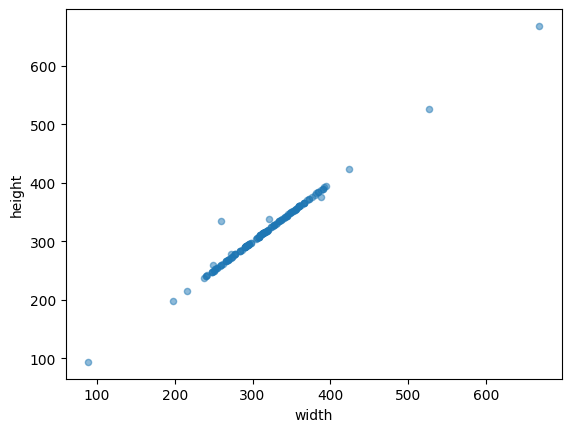

In [12]:
df.plot(kind='scatter', x='width', y='height', alpha=0.5)

# Grounded-SAM

In [1]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology

/home/eduardo/anaconda3/envs/tech/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model = GroundedSAM(ontology=CaptionOntology({"a circle shape object that resambles a coin": "coin"}))

trying to load grounding dino directly


/home/eduardo/anaconda3/envs/tech/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904035/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [3]:
out = base_model.predict("/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin/data/img/0000.jpeg")

/home/eduardo/anaconda3/envs/tech/lib/python3.11/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/eduardo/anaconda3/envs/tech/lib/python3.11/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [4]:
out

Detections(xyxy=array([[-4.8614502e-02,  1.3524658e+01,  1.5003546e+02,  1.9098279e+02]],
      dtype=float32), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False]]]), confidence=array([0.5783059], dtype=float32), class_id=array([0]), tracker_id=None)

In [18]:
import cv2
import numpy as np
import supervision as sv

In [20]:
mask_annotator = sv.MaskAnnotator()
img = cv2.imread("/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin/data/img/0000.jpeg")
mask = cv2.imread("/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin/data/mask/0000.png")
annotated_img = mask_annotator.annotate(img.copy(), out)

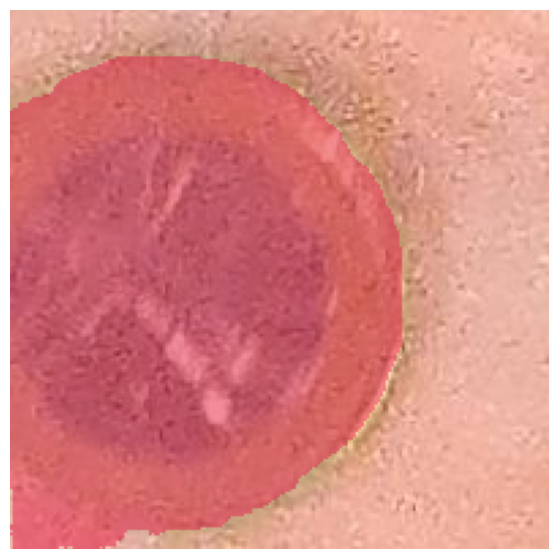

In [10]:
sv.plot_image(annotated_img, (7,7))

In [11]:
def calculate_iou(ground_truth, prediction):
    """
    Calculate Intersection over Union (IoU) for a segmentation problem.

    Args:
        ground_truth (numpy.ndarray): The ground truth binary mask.
        prediction (numpy.ndarray): The predicted binary mask.

    Returns:
        float: The IoU score.
    """
    # Ensure both masks are binary (0 or 1)
    ground_truth = (ground_truth > 0).astype(np.uint8)
    prediction = (prediction > 0).astype(np.uint8)

    # Calculate the intersection and union
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [27]:
calculate_iou(mask, out.mask.transpose(1,2,0).astype(np.uint8))

0.9426362896663955

# Classical CV

In [1]:
%cd ../..

/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin


In [2]:
import os
from dataclasses import dataclass

import cv2
import optuna
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/home/eduardo/anaconda3/envs/tech/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_path = sorted([f"data/img/{f}" for f in os.listdir('data/img/')])
mask_path = sorted([f"data/mask/{f}" for f in os.listdir('data/mask/')])

In [4]:
# Set the random seed to 42 for reproducibility
np.random.seed(42)
# Create an array with all idx
idx = np.arange(len(img_path))
# Select a few index for training
train_idx = np.random.choice(idx, len(img_path) - 0, replace=False)
# Selecting the rest for validation
valid_idx = np.setdiff1d(idx, train_idx)
# Split validation one more time to get validation and test
valid_idx, test_idx = np.split(valid_idx, 2)

In [5]:
# Getting the paths for each set
x_train = np.array(img_path)[train_idx]
y_train = np.array(mask_path)[train_idx]
x_valid = np.array(img_path)[valid_idx]
y_valid = np.array(mask_path)[valid_idx]
x_test = np.array(img_path)[test_idx]
y_test = np.array(mask_path)[test_idx]

## Looking at the coins masks

(array([ 4., 23., 26., 44., 31.,  9.,  5.,  2.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([0.25310549, 0.29043086, 0.32775623, 0.36508159, 0.40240696,
        0.43973233, 0.4770577 , 0.51438307, 0.55170844, 0.5890338 ,
        0.62635917, 0.66368454, 0.70100991, 0.73833528, 0.77566065,
        0.81298601, 0.85031138, 0.88763675, 0.92496212, 0.96228749,
        0.99961286]),
 <BarContainer object of 20 artists>)

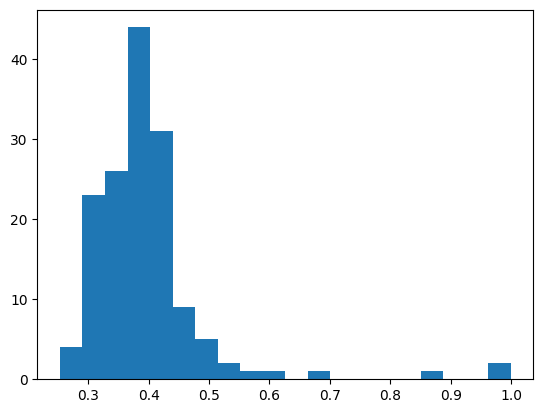

In [15]:
# Calculating the radius in pixel of the coins normalized by its total area
radius = []
for mask in mask_path:
    mask = cv2.imread(mask)
    radius.append(
        np.sum(mask > 0) / 3 / (mask.shape[0] * mask.shape[1])
    )

plt.hist(radius, bins=20)

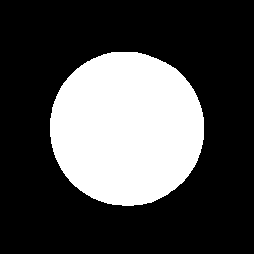

In [37]:
Image.open(mask_path[88])

In [31]:
np.argsort(radius)[::-1][:5]

array([ 63, 118,  62, 113,  40])

In [32]:
np.argsort(radius)[:5]

array([ 58,  52,  87, 125,  88])

## Edge Detection

In [7]:
def calculate_iou(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Calculate Intersection over Union (IoU) for a segmentation problem.

    Args:
        ground_truth (numpy.ndarray): The ground truth binary mask.
        prediction (numpy.ndarray): The predicted binary mask.

    Returns:
        float: The IoU score.
    """
    # Ensure both masks are binary (0 or 1)
    ground_truth = (ground_truth > 0).astype(np.uint8)
    prediction = (prediction > 0).astype(np.uint8)

    # Calculate the intersection and union
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [8]:
@dataclass
class SegmentationOutput:
    iou: float
    image: np.ndarray
    prediction: np.ndarray
    ground_truth: np.ndarray
    image_path: str
    ground_truth_path: str

    def plot_segmentation(self, alpha=0.5) -> None:
        # Create a copy of the original image to avoid modifying it
        result1 = self.image.copy()
        result2 = self.image.copy()

        # Convert the mask to a 3-channel format (if it's single-channel)
        if len(self.prediction.shape) == 2:
            mask = cv2.cvtColor(self.prediction.copy(), cv2.COLOR_GRAY2BGR)

                # Convert the mask to a 3-channel format (if it's single-channel)
        if len(self.ground_truth.shape) == 2:
            ground_truth = cv2.cvtColor(self.ground_truth.copy(), cv2.COLOR_GRAY2BGR)

        # Convert masks to yellow
        mask[:, :, 0] = 0
        mask[:, :, 1][mask[:, :, 1]>0] = 255
        mask[:, :, 2][mask[:, :, 2]>0] = 255
        # Convert ground truth to green
        ground_truth[:, :, 0] = 0
        ground_truth[:, :, 1][ground_truth[:, :, 1]>0] = 255
        ground_truth[:, :, 2] = 0

        # Blend the mask and the original image
        cv2.addWeighted(mask, alpha, result1, 1 - alpha, 0, result1)
        cv2.addWeighted(ground_truth, alpha, result2, 1 - alpha, 0, result2)

        fig, axes = plt.subplots(1, 2)
        plt.suptitle(f"IoU: {self.iou*100:.2f}%")

        axes[0].set_title("Prediction")
        axes[0].imshow(result1)
        axes[1].set_title("Ground Truth")
        axes[1].imshow(result2)

        axes[0].axis("off")
        axes[1].axis("off")

In [9]:
class SegmentationPipeline:
    def __init__(
            self,
            blur_kernel_size: int = 5,
            blur_sigma: int = 0,
            canny_threshold_1: int = 40,
            canny_threshold_2: int = 120,
            clip_limit: float = 2.0,
            tile_grid_size: int = 8,
            brightness_alpha: float = 1.0,
            brightness_beta: int = 0,
            pre_blur: bool = False,
            sharpen_mode: str = None,
            kernel_size: int = 9,
            sigma_x: int = 10,
            sigma_y: int = 10,
    ) -> None:
        self.blur_kernel_size = blur_kernel_size
        self.blur_sigma = blur_sigma
        self.canny_threshold_1 = canny_threshold_1
        self.canny_threshold_2 = canny_threshold_2
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.brightness_alpha = brightness_alpha
        self.brightness_beta = brightness_beta
        self.pre_blur = pre_blur
        self.sharpen_mode = sharpen_mode
        self.kernel_size = kernel_size
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y

    def _get_contours(self, img_path: str) -> tuple[np.ndarray, tuple[np.ndarray]]:
        """
        Get the contours of the objects in the image.

        Args:
            img_path (str): The path to the image.

        Returns:
            np.ndarray: The contours of the objects in the image.
        """
        # Load the input image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Adjust brightness and contrast
        adjusted_image = cv2.convertScaleAbs(image, alpha=self.brightness_alpha, beta=self.brightness_beta)

        # Convert the adjusted image to grayscale
        gray = cv2.cvtColor(adjusted_image, cv2.COLOR_RGB2GRAY)

        # Enhance the grayscale image
        enhanced_gray = self._enhance_gray_image(gray.copy())

        # Apply Canny edge detection
        edges = cv2.Canny(enhanced_gray, self.canny_threshold_1, self.canny_threshold_2)

        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        return image, contours

    def _enhance_gray_image(self, image: np.ndarray) -> np.ndarray:
        # Apply contrast enhancement using CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=(self.tile_grid_size, self.tile_grid_size))
        enhanced_gray = clahe.apply(image)

        # Apply Gaussian blur to reduce noise
        if self.pre_blur:
            enhanced_gray = cv2.GaussianBlur(enhanced_gray.copy(), (self.blur_kernel_size, self.blur_kernel_size), self.blur_sigma)
            enhanced_gray = self._apply_sharpening(enhanced_gray.copy())
        else: 
            enhanced_gray = self._apply_sharpening(enhanced_gray.copy())
            enhanced_gray = cv2.GaussianBlur(enhanced_gray.copy(), (self.blur_kernel_size, self.blur_kernel_size), self.blur_sigma)
        
        return enhanced_gray

    def _apply_sharpening(self, image: np.ndarray) -> np.ndarray:
        if self.sharpen_mode is None:
            sharpened = image
        elif self.sharpen_mode == "default":
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            sharpened = cv2.filter2D(image, -1, kernel)
        elif self.sharpen_mode == "gaussian":
            sharpened = cv2.GaussianBlur(image, (0, 0), 3)
            sharpened = cv2.addWeighted(sharpened, 1.5, sharpened, -0.5, 0)
        elif self.sharpen_mode == "laplacian":
            sharpened = cv2.Laplacian(image, -1, ksize=3)
        else:
            raise ValueError(f"Unknown sharpening mode: {self.sharpen_mode}")

        return sharpened
    
    def _create_coin_mask(self, image: np.ndarray, contours: tuple[np.ndarray]) -> np.ndarray:
        # Create an empty black image with the same dimensions as the input image
        mask = np.zeros_like(image)

        # Draw the filled contours on the mask
        cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

        # Convert the mask to grayscale
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Threshold the mask to create a binary mask
        _, binary_mask = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)

        smoothed_mask = cv2.GaussianBlur(binary_mask, (self.kernel_size,self.kernel_size), sigmaX=self.sigma_x, sigmaY=self.sigma_y)

        return smoothed_mask
    
    def _fill_inner_mask(self, smoothed_mask: np.ndarray) -> np.ndarray:
        # Find contours in the smoothed mask
        contours, _ = cv2.findContours(smoothed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty black mask with the same dimensions as the smoothed mask
        filled_mask = np.zeros_like(smoothed_mask)

        # Fill the inner contours
        for contour in contours:
            cv2.drawContours(filled_mask, [contour], -1, 255, thickness=cv2.FILLED)

        return filled_mask
    
    def segment(self, images: np.array, masks: np.array) -> list[SegmentationOutput]:
        outputs = []
        for img_path, mask_path in zip(images, masks):     
            ground_truth = cv2.imread(mask_path).mean(axis=-1).astype(np.uint8)
            image, contours = self._get_contours(img_path)
            binary_mask = self._create_coin_mask(image, contours)
            prediction = self._fill_inner_mask(binary_mask)
            iou = calculate_iou(ground_truth, prediction)
            outputs.append(SegmentationOutput(iou, image, prediction, ground_truth, img_path, mask_path))

        return outputs

In [10]:
def objective(trial: optuna.Trial) -> float:
    # Define the hyperparameters to be tuned
    params = {
        "blur_kernel_size": trial.suggest_categorical("blur_kernel_size", [i for i in range(2, 20) if i % 2 == 1]), # Suggest only odd numbers
        "blur_sigma": trial.suggest_int("blur_sigma", 0, 15),
        "canny_threshold_1": trial.suggest_int("canny_threshold_1", 0, 255),
        "canny_threshold_2": trial.suggest_int("canny_threshold_2", 0, 255),
        "clip_limit": trial.suggest_float("clip_limit", 0.0, 10.0),
        "tile_grid_size": trial.suggest_categorical("tile_grid_size", [8, 16, 32]),
        "brightness_alpha": trial.suggest_float("brightness_alpha", 0.0, 3.0),
        "brightness_beta": trial.suggest_int("brightness_beta", -100, 100),
        "sharpen_mode": trial.suggest_categorical("sharpen_mode", [None, "default", "gaussian", "laplacian"]),
        "pre_blur": trial.suggest_categorical("pre_blur", [True, False]),
        "kernel_size": trial.suggest_categorical("kernel_size", [i for i in range(2, 20) if i % 2 == 1]),
        "sigma_x": trial.suggest_int("sigma_x", 0, 15),
        "sigma_y": trial.suggest_int("sigma_y", 0, 15),
    }

    pipeline = SegmentationPipeline(**params)
    outputs = pipeline.segment(x_train, y_train)

    # Calculate the mean IoU score
    iou = np.mean([out.iou for out in outputs])

    return iou

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-09-27 16:04:16,712] A new study created in memory with name: no-name-24f60ae6-8c99-491d-b2c2-08f9b7ddff2a
[I 2023-09-27 16:04:20,822] Trial 0 finished with value: 0.552863831484946 and parameters: {'blur_kernel_size': 3, 'blur_sigma': 13, 'canny_threshold_1': 177, 'canny_threshold_2': 173, 'clip_limit': 7.708442018146569, 'tile_grid_size': 16, 'brightness_alpha': 0.8870248582848028, 'brightness_beta': 0, 'sharpen_mode': None, 'pre_blur': False, 'kernel_size': 7, 'sigma_x': 13, 'sigma_y': 5}. Best is trial 0 with value: 0.552863831484946.
[I 2023-09-27 16:04:22,568] Trial 1 finished with value: 0.0 and parameters: {'blur_kernel_size': 15, 'blur_sigma': 0, 'canny_threshold_1': 183, 'canny_threshold_2': 7, 'clip_limit': 9.937965455145862, 'tile_grid_size': 32, 'brightness_alpha': 0.13432370195198928, 'brightness_beta': -81, 'sharpen_mode': 'laplacian', 'pre_blur': False, 'kernel_size': 15, 'sigma_x': 0, 'sigma_y': 12}. Best is trial 0 with value: 0.552863831484946.
[I 2023-09-27 1

In [22]:
study.best_params

{'blur_kernel_size': 9,
 'blur_sigma': 0,
 'canny_threshold_1': 13,
 'canny_threshold_2': 206,
 'clip_limit': 0.8663238625035552,
 'tile_grid_size': 16,
 'brightness_alpha': 1.0231042369182493,
 'brightness_beta': 27,
 'sharpen_mode': 'default',
 'pre_blur': False,
 'kernel_size': 5,
 'sigma_x': 0,
 'sigma_y': 15}

In [23]:
study.best_value

0.8040746816585128

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [11]:
best_params = {'blur_kernel_size': 9,
 'blur_sigma': 0,
 'canny_threshold_1': 13,
 'canny_threshold_2': 206,
 'clip_limit': 0.8663238625035552,
 'tile_grid_size': 16,
 'brightness_alpha': 1.0231042369182493,
 'brightness_beta': 27,
 'sharpen_mode': 'default',
 'pre_blur': False,
 'kernel_size': 5,
 'sigma_x': 0,
 'sigma_y': 15}

In [12]:
pipeline = SegmentationPipeline(**best_params)
outputs = pipeline.segment(img_path, mask_path)

In [17]:
outputs[0].ground_truth

39204

In [26]:
img_path[0].split("/")[-1].split(".")[0]

'0000'

In [24]:
outputs[0].prediction.max()

255

In [27]:
np.mean([out.iou for out in outputs])

0.799585108673095

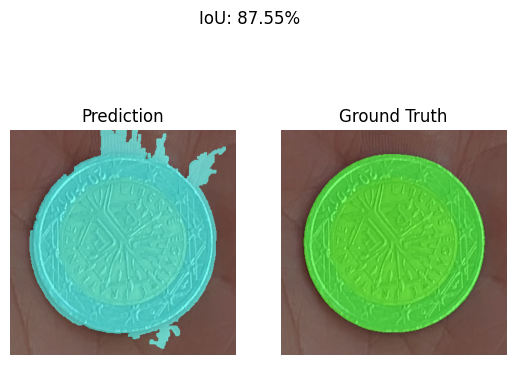

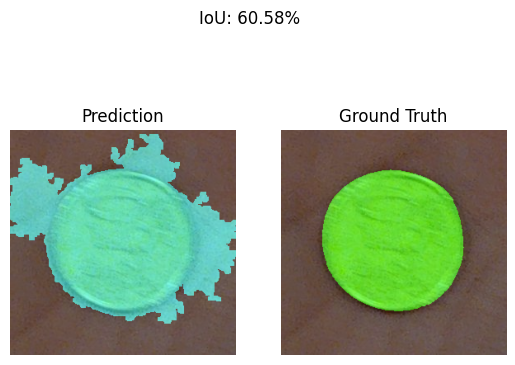

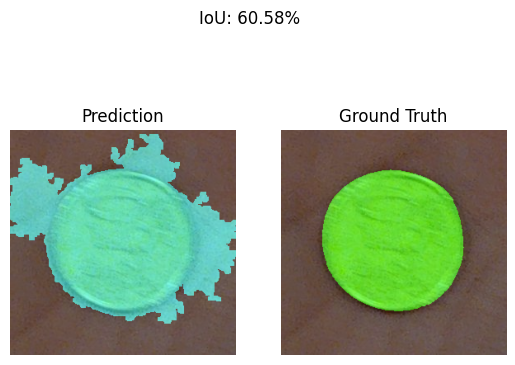

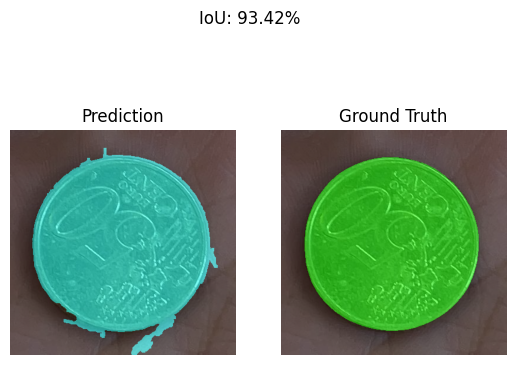

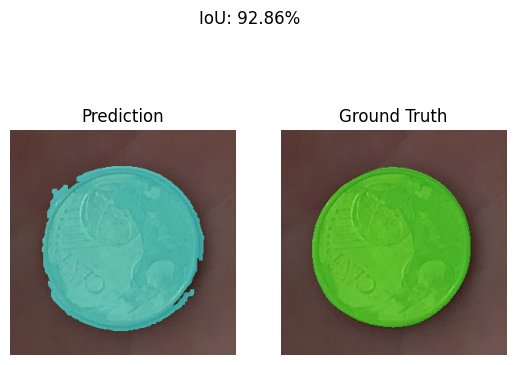

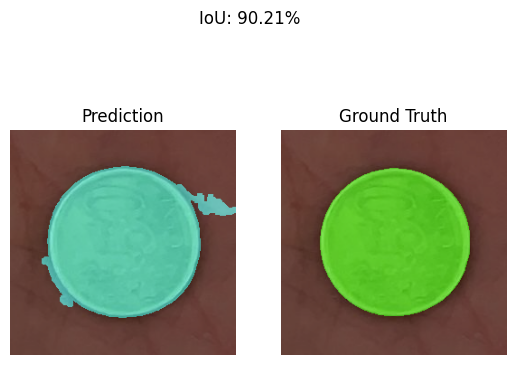

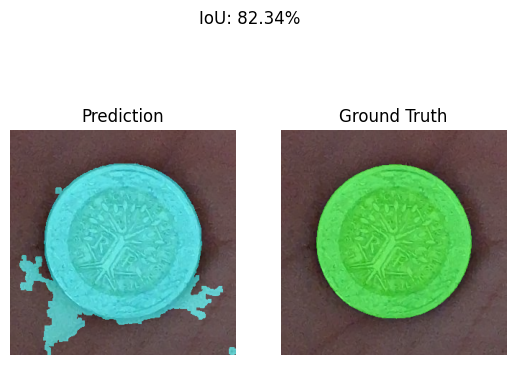

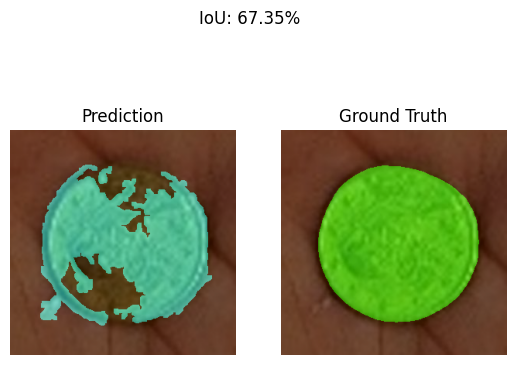

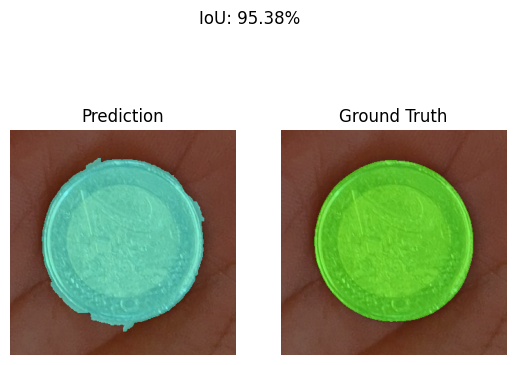

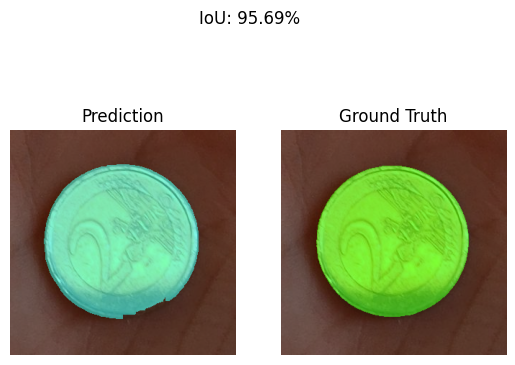

In [29]:
for output in np.random.choice(outputs, size=10):
    output.plot_segmentation()